In [1]:
from pinntorch import *
from functools import partial
from matplotlib.ticker import FuncFormatter
import matplotlib
from matplotlib.transforms import Bbox

# use GPU for faster training
#torch.set_default_tensor_type('torch.cuda.FloatTensor')
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device='cpu'

In [2]:
k = 1.0
L = 5.0
T = 12.5

X_DOMAIN = (0.0, L)
T_DOMAIN = (0.0, T)

def exact_solution(x, t):
    return torch.sin(torch.pi*x/L)*torch.exp(-k*((torch.pi**2)/(L**2))*t)

### Let us first define some book keeping plotting functions

In [3]:
def plot_data(x, t, data, grid_shape):
    z = data
    color_map = cm.winter
    x = x.cpu().detach().numpy().reshape(grid_shape)
    t = t.cpu().detach().numpy().reshape(grid_shape)
    z = z.cpu().detach().numpy().reshape(grid_shape)

    fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
    ax.set(xlabel='x (location)', ylabel='t (time)', zlabel='function value')

    ls = LightSource(270, 45)

    surf = ax.plot_surface(x, t, z, cmap=color_map, linewidth=0, antialiased=False, shade=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)

def plot_heatmap(x, t, data, grid_shape):
    z = data
    color_map = plt.cm.winter
    x = x.cpu().detach().numpy().reshape(grid_shape)
    t = t.cpu().detach().numpy().reshape(grid_shape)
    z = z.cpu().detach().numpy().reshape(grid_shape)
    print(z)
    print((x.min(), x.max(), t.min(), t.max()))

    plt.imshow(z, cmap=color_map, aspect='auto', origin='upper', extent=(t.min(), t.max(), x.min(), x.max()))
    plt.colorbar(label='Function Value')
    plt.xlabel('t (time)')
    plt.ylabel('x (location)')
    plt.title('Heat Map of Function')
    plt.show()

def plot_pareto_front(L_D, L_P, data_color, cmap = 'virdis'):
    
    plt.scatter(L_D, L_P, c=data_color.detach().numpy(), cmap='viridis')
    
    cbar = plt.colorbar()
    cbar.set_label(r' $α$ Values')

    plt.xlabel(r"data loss ($L_d$)")
    plt.ylabel(r"physics loss ($L_p$)")
    plt.title("Multi-objective optimization L = $α.L_d + (1-α)L_p$")

    #plt.savefig("heat_pareto_unstructured.png")
    plt.show()

In [4]:
def data_loss(model: nn.Module, data: torch.Tensor = None, x: torch.Tensor = None, t:torch.Tensor = None) -> torch.float:
    """"Caculates the data loss"""
    u_n = f(model, x, t) # evaluating the model
    # MSE loss 
    diff = u_n - data    # u_exact + gaussian noise 
    
    loss = diff.pow(2).mean()

    return loss

def physics_loss(
    model: nn.Module, x: torch.Tensor = None, t: torch.Tensor = None
) -> torch.float:

    pde_loss_pre = df(model, x, t, wrt=1, order=1) - k*df(model, x, t, wrt=0, order=2)
    pde_loss = pde_loss_pre.pow(2).mean()
    

    t_raw = unique_excluding(t, 0.)
    x_left_boundary = fill_like(t_raw, 0.)
    x_right_boundary = fill_like(t_raw, L)
    x_raw = unique_excluding(x)
    t_zero = fill_like(x_raw, 0.)

    # dirichlet boundary conditions.  
    boundary_left = f(model, x_left_boundary, t_raw).pow(2).mean()
    boundary_right = f(model, x_right_boundary, t_raw).pow(2).mean()
    boundary_loss = boundary_left + boundary_right

    # initial
    initial_loss_pre = f(model, x_raw, t_zero) - torch.sin(np.pi/L * x_raw).reshape(-1, 1)
    initial_loss = initial_loss_pre.pow(2).mean()
    
    # together
    conditional_loss = boundary_loss + initial_loss
    
    final_loss = pde_loss + conditional_loss
    return final_loss

def val_loss(
    model: nn.Module, x: torch.Tensor, t: torch.Tensor) -> torch.float:

    pde_loss_pre = df(model, x, t, wrt=1, order=1) - k*df(model, x, t, wrt=0, order=2)
    pde_loss = pde_loss_pre.pow(2).mean()
    
    return pde_loss

def total_loss(model: nn.Module, data: torch.Tensor, x_data: torch.Tensor, t_data: torch.Tensor, x_physics: torch.Tensor, t_physics: torch.Tensor, alpha: torch.float) -> torch.float:

    loss_data = data_loss(model, data, x_data, t_data)

    loss_physics = physics_loss(model, x_physics, t_physics)

    total = alpha*loss_data + (1 - alpha)* loss_physics 
    
    return total  




In [5]:
def create_noisy_data(std_dev, exact_soln):

    """adds gaussian noise to the data"""

    return exact_soln + torch.randn(exact_soln.shape)*std_dev 

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.57862417e-02  1.53995883e-02  1.50224054e-02 ...  1.19305543e-04
   1.16383344e-04  1.13532828e-04]
 [ 3.15685496e-02  3.07953395e-02  3.00410669e-02 ...  2.38581357e-04
   2.32737686e-04  2.27037352e-04]
 ...
 [ 3.15686762e-02  3.07954643e-02  3.00411880e-02 ...  2.38582317e-04
   2.32738617e-04  2.27038268e-04]
 [ 1.57861430e-02  1.53994923e-02  1.50223114e-02 ...  1.19304801e-04
   1.16382616e-04  1.13532114e-04]
 [-8.74227766e-08 -8.52815276e-08 -8.31927167e-08 ... -6.60703325e-10
  -6.44520437e-10 -6.28734509e-10]]
(0.0, 5.0, 0.0, 12.5)


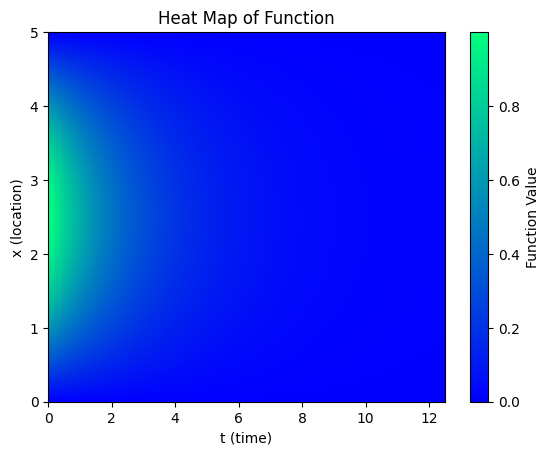

In [6]:
x_train_d, t_train_d = generate_grid((20,20), domain=(X_DOMAIN, T_DOMAIN))
x_train_p, t_train_p = generate_grid((20,20), domain=(X_DOMAIN, T_DOMAIN))
x_val, t_val = generate_grid((39,39), domain=(X_DOMAIN, T_DOMAIN))
x_plot, t_plot = generate_grid((200,200), domain=(X_DOMAIN, T_DOMAIN))

exact_soln = exact_solution(x_train_d, t_train_d)

plot_solution = exact_solution(x_plot, t_plot)
plot_heatmap(x_plot, t_plot, plot_solution, grid_shape=(200, 200))

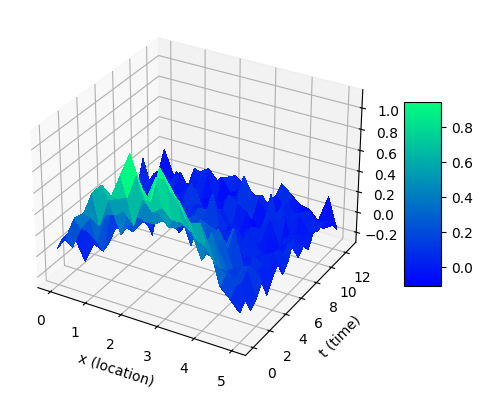

In [7]:
alphas = 1-torch.logspace(start=-2, end=0.0, steps=20, base=80)

settings = {}
settings['seed'] = 11373
settings['alphas'] = alphas.cpu()
settings['n_train_points'] = 20
settings['n_val_points'] = 39
settings['noise_level'] = 0.1
settings['start_learning_rate'] = 0.003
settings['epochs'] = 10_000

torch.manual_seed(settings['seed'])

input_data = create_noisy_data(settings['noise_level'], exact_soln)

plot_data(x_train_d, t_train_d, input_data, (20, 20))

def custom_color_normalize(value):
    return value**80

In [8]:
def scalar_training(alphas, input_data, x_train_d, t_train_d, x_train_p, t_train_p, x_val, t_val):
    L_p = []
    L_d = []
    L_VAL = []
    LR = []
    
    models_trained = []
    for i, alpha in enumerate(alphas):
        print("i:", i, "alpha:", alpha)
        
        loss_fn = partial(total_loss,data = input_data, x_data=x_train_d, t_data=t_train_d, x_physics=x_train_p, t_physics=t_train_p, alpha = alpha)
        
        torch.manual_seed(7245)
        
        model = PINN(2, 4, 50, 1)
        model.to(device)
      
        callbacks = [AllDataMonitor(
            partial(data_loss, data=input_data, x=x_train_d, t=t_train_d), 
            partial(physics_loss, x=x_train_p, t=t_train_p), 
            partial(val_loss, x=x_val, t=t_val))]
        
        trained_model = train_model(
        model = model, 
        loss_fn=loss_fn,
        optimizer_fn=partial(torch.optim.Adam, lr=settings['start_learning_rate']),
        max_epochs = settings['epochs'],
        lr_decay = 2e-2,
        epoch_callbacks = callbacks)

        L_p.append(np.array(callbacks[0].physics_history))
        L_d.append(np.array(callbacks[0].data_history))
        LR.append(np.array(callbacks[0].lr_history))
        L_VAL.append(np.array(callbacks[0].val_history))
        models_trained.append(trained_model)

    return L_p, L_d, LR, L_VAL, models_trained

### Training with exact solution

In [9]:
Loss_p, Loss_d, LR, Loss_VAL, models_trained = scalar_training(alphas, input_data, x_train_d, t_train_d, x_train_p, t_train_p, x_val, t_val)

i: 0 alpha: tensor(0.9998)
i: 1 alpha: tensor(0.9998)
i: 2 alpha: tensor(0.9996)
i: 3 alpha: tensor(0.9994)
i: 4 alpha: tensor(0.9990)
i: 5 alpha: tensor(0.9984)
i: 6 alpha: tensor(0.9975)
i: 7 alpha: tensor(0.9961)
i: 8 alpha: tensor(0.9937)
i: 9 alpha: tensor(0.9901)
i: 10 alpha: tensor(0.9843)
i: 11 alpha: tensor(0.9750)
i: 12 alpha: tensor(0.9604)
i: 13 alpha: tensor(0.9372)
i: 14 alpha: tensor(0.9004)
i: 15 alpha: tensor(0.8420)
i: 16 alpha: tensor(0.7494)
i: 17 alpha: tensor(0.6025)
i: 18 alpha: tensor(0.3695)
i: 19 alpha: tensor(0.)


In [10]:
def custom_color_normalize(value):
    return value**80

def log_tick_formatter(val, pos):
    if np.isclose(val**(1./80.), show_alphas_scaled).any():
        if val == 1.0:
            return f"({val**(1./80.):.5f})"
        return f"{val**(1./80.):.5f}"
    return ""
    
def tick_formatter(val, pos):
    skip_indices = [1,2,3,5,15,16,17,18,19,20]  # Adjust the indices you want to skip
    if pos in skip_indices:
        return ''
    elif pos == 1:
        return '('+str(1.0)+')'
    return alphas[pos]
    
def find_last_threshold_index(physics, validation, threshold = 0.0):
    over = (validation - physics) > threshold
    reversed_arr = np.flipud(over)
    index = len(over) - np.where(reversed_arr == False)[0][0] - 1
    return index

def plot_pareto_front(L_D, L_P, data_color):
    cmap = matplotlib.colormaps['jet']
    plt.figure(figsize=(5,4))
    low_noise_points = plt.scatter(L_D, L_P, c=custom_color_normalize(data_color), cmap=cmap) 
    # Add colorbar for the z values
    cbar_lown = plt.colorbar(low_noise_points, ticks=custom_color_normalize(np.concatenate(([1.0], data_color))), format=FuncFormatter(tick_formatter))

    cbar_lown.set_label(r' $α$ (log scaled)', fontsize=13)
    
    plt.ylabel(r"$\mathcal{L}_\mathrm{PHYSICS}$", loc='center', fontsize=13)
    plt.xlabel(r"$\mathcal{L}_\mathrm{DATA}$", loc='center', fontsize=13)

    plt.grid()

    bbox_instance = Bbox.from_bounds(0.1, -0.1, 5.2, 3.8)

    #plt.savefig('../plots/heat_L5k1_pareto_normal.png', dpi=600, bbox_inches=bbox_instance)
    plt.show()

def get_best_indices(physics, validation, threshold):
    best_indices = []
    for i in range(len(physics)):
        best_indices.append(find_last_threshold_index(physics[i], validation[i], threshold))
    return best_indices

In [11]:
heat_data = np.array(Loss_d)
heat_physics = np.array(Loss_p)
heat_val = np.array(Loss_VAL) 
alphas = np.array(alphas)

In [12]:
# determine the converged/not overfitted indices for every model via threshold between physics and validation

best_indices = get_best_indices(heat_physics, heat_val, 0.0)

pareto_physics = [heat_physics[i][best_indices[i]] for i in range(len(heat_physics))]
pareto_data = [heat_data[i][best_indices[i]] for i in range(len(heat_data))]

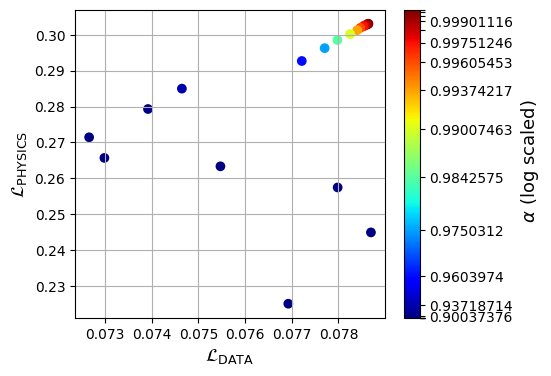

In [13]:
plot_pareto_front(pareto_data, pareto_physics, alphas)